In [2]:
import cv2
import os
import numpy as np
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy.io as io
import PIL.Image as Image
from skimage.transform import resize
from matplotlib import cm as CM
from typing import List, Tuple
import h5py
import json

In [13]:
labels = [[149, 535], [167, 516], [171, 509], [191, 680], [204, 692], [330, 735], [680, 692], [498, 593], [510, 487], [495, 441]]
path = '/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/whatsapp/wimg2.jpeg'

In [27]:
def create_hdf5(dataset_name: str,
                train_size: int,
                valid_size: int,
                img_size: Tuple[int, int],
                in_channels: int=3):
    """
    Create empty training and validation HDF5 files with placeholders
    for images and labels (density maps).

    Note:
    Datasets are saved in [dataset_name]/train.h5 and [dataset_name]/valid.h5.
    Existing files will be overwritten.

    Args:
        dataset_name: used to create a folder for train.h5 and valid.h5
        train_size: no. of training samples
        valid_size: no. of validation samples
        img_size: (width, height) of a single image / density map
        in_channels: no. of channels of an input image

    Returns:
        A tuple of pointers to training and validation HDF5 files.
    """
    # create output folder if it does not exist
    os.makedirs(dataset_name, exist_ok=True)

    # create HDF5 files: [dataset_name]/(train | valid).h5
    train_h5 = h5py.File(os.path.join(dataset_name, 'train.h5'), 'w')
    valid_h5 = h5py.File(os.path.join(dataset_name, 'valid.h5'), 'w')

    # add two HDF5 datasets (images and labels) for each HDF5 file
    for h5, size in ((train_h5, train_size), (valid_h5, valid_size)):
        h5.create_dataset('images', (size, in_channels, *img_size))
        h5.create_dataset('labels', (size, 1, *img_size))

    return train_h5, valid_h5

In [18]:
label_path = '/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/Datalabel/0.json'
with open(label_path,'r') as f:
    data = json.load(f)
labels = np.array(data['labels'])
print(type(labels), labels.shape)

<class 'numpy.ndarray'> (14, 2)


In [19]:
def get_density(label_path, w, h):
    with open(label_path,'r') as f:
        data = json.load(f)
    labels = np.array(data['labels'])
    new_pts = np.zeros(labels.shape)
    for i, pt in enumerate(labels):
        new_pts[i][0] = pt[0]*(224/w)
        new_pts[i][1] = pt[1]*(224/h)
    # print(gt)
    k = np.zeros((224,224))
    # print(len(gt))
    for i in range(0,len(new_pts)):
        # print(i)
        if int(new_pts[i][1])<224 and int(new_pts[i][0])<224:
            k[int(new_pts[i][1]),int(new_pts[i][0])] = 100
    k = gaussian_filter(k, sigma=(1, 1), order=0)
    return k

In [25]:
def generate_data():
    """Generate HDF5 files for nwpu dataset."""

    train_h5, valid_h5 = create_hdf5('Alzahia_dataset',
                                     train_size=22,
                                     valid_size=0,
                                     img_size=(224, 224),
                                     in_channels=3)

    # load labels infomation from provided MATLAB file
    # it is a numpy array with (x, y) objects position for subsequent frames

    def fill_h5(h5, init_frame=0):
        """
        Save images and labels in given HDF5 file.

        Args:
            h5: HDF5 file
            labels: the list of labels
            init_frame: the first frame in given list of labels
        """
        for i, key in enumerate(range(20)):
            # path to the next frame (filename convention: seq_XXXXXX.jpg)
            img_path = f"/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/Datalabel/{str(key)}.jpg"
            density_path = f"/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/Datalabel/{str(key)}.json"
            print(i)

            # get an image as numpy array
            try:
                image = np.array(Image.open(img_path).resize((224,224)), dtype=np.float32) / 255
                w, h = Image.open(img_path).size
            except:
                print('image not present',key,'.jpg')
                continue
            image = np.transpose(image, (2, 0, 1))
            # generate a density map by applying a Gaussian filter
            try:
                label = get_density(density_path, w, h)
            except:
                print('density not present',key,'.h5')
                continue
            # save data to HDF5 file
            h5['images'][i - init_frame] = image
            h5['labels'][i - init_frame, 0] = label


    # use first 1500 frames for training and the last 500 for validation
    fill_h5(train_h5)

    # close HDF5 file
    train_h5.close()


In [28]:
generate_data()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
image not present 16 .jpg
17
18
19


In [21]:
path = '/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/Datalabel/0.json'
w, h = Image.open('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/Datalabel/0.jpg').size
k = get_density(path,w,h)

1024 768


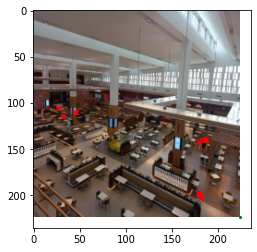

In [24]:
img = plt.imread('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/Datalabel/0.jpg')

new_pts = np.zeros((14,2))
w, h = Image.open('/media/idt/c9fed8d0-a409-4fac-b88e-61892dc0e35b/objects_counting_dmap/Datalabel/0.jpg').size
print(w,h)
for i, pt in enumerate(labels):
    new_pts[i][0] = pt[0]*(224/w)
    new_pts[i][1] = pt[1]*(224/h)
plt.imshow(resize(img, (224, 224)))
plt.plot(224, 224, "og", markersize=2)  # og:shorthand for green circle
plt.scatter(new_pts[:,0], new_pts[:,1], marker="x", color="red", s=20)
plt.show()

In [8]:

k = np.zeros((224,224))
# print(len(gt))
for i in range(0,len(new_pts)):
    # print(i)
    if int(new_pts[i][1])<224 and int(new_pts[i][0])<224:
        k[int(new_pts[i][1]),int(new_pts[i][0])] = 100
k = gaussian_filter(k, sigma=(1, 1), order=0)

(224, 224)


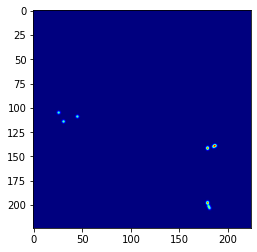

In [22]:
groundtruth = np.asarray(k)
print(groundtruth.shape)
plt.imshow(groundtruth,cmap=CM.jet)